## The fifth In-class-exercise (2/23/2021, 20 points in total)

In exercise-03, I asked you to collected 500 textual data based on your own information needs (If you didn't collect the textual data, you should recollect for this exercise). Now we need to think about how to represent the textual data for text classification. In this exercise, you are required to select 10 types of features (10 types of features but absolutely more than 10 features) in the followings feature list, then represent the 500 texts with these features. The output should be in the following format:
![image.png](attachment:image.png)

The feature list:

* (1) tf-idf features
* (2) POS-tag features: number of adjective, adverb, auxiliary, punctuation, complementizer, coordinating conjunction, subordinating conjunction, determiner, interjection, noun, possessor, preposition, pronoun, quantifier, verb, and other. (select some of them if you use pos-tag features)
* (3) Linguistic features:
  * number of right-branching nodes across all constituent types
  * number of right-branching nodes for NPs only
  * number of left-branching nodes across all constituent types
  * number of left-branching nodes for NPs only
  * number of premodifiers across all constituent types
  * number of premodifiers within NPs only
  * number of postmodifiers across all constituent types
  * number of postmodifiers within NPs only
  * branching index across all constituent types, i.e. the number of right-branching nodes minus number of left-branching nodes
  * branching index for NPs only
  * branching weight index: number of tokens covered by right-branching nodes minus number of tokens covered by left-branching nodes across all categories
  * branching weight index for NPs only 
  * modification index, i.e. the number of premodifiers minus the number of postmodifiers across all categories
  * modification index for NPs only
  * modification weight index: length in tokens of all premodifiers minus length in tokens of all postmodifiers across all categories
  * modification weight index for NPs only
  * coordination balance, i.e. the maximal length difference in coordinated constituents
  
  * density (density can be calculated using the ratio of folowing function words to content words) of determiners/quantifiers
  * density of pronouns
  * density of prepositions
  * density of punctuation marks, specifically commas and semicolons
  * density of auxiliary verbs
  * density of conjunctions
  * density of different pronoun types: Wh, 1st, 2nd, and 3rd person pronouns
  
  * maximal and average NP length
  * maximal and average AJP length
  * maximal and average PP length
  * maximal and average AVP length
  * sentence length

* Other features in your mind (ie., pre-defined patterns)

In [54]:
# Retrieve data
import requests

url = 'https://portal.torcherbaria.org/portal/collections/download/downloadhandler.php'
schema = 'dwc' # Darwin Core
file_format = 'csv' #form field name is 'format'
cset = 'utf-8'
publicsearch = '1'
taxonFilterCode = '0'
sourcepage = 'specimen'
images = '1' # include images - 1, only includes image records
zip_file = '0' # form field name is zip, default to not zip file
if images == '1': # results must be zipped to get both specimen and image records
  zip_file = '1' # form field name is zip
# db=370 specifies the BRIT dataset, this can be changed to specify other datasets
searchvar = 'db=370&state=Texas&county=Tarrant&hasimages=1'

r = requests.post(url, data={'schema': schema, 'format': file_format, 
    'cset': cset, 'publicsearch': publicsearch, 
    'taxonFilterCode': taxonFilterCode, 
    'images': images, 'zip':zip_file,
    'sourcepage': sourcepage, 'searchvar': searchvar},
    stream=True)

# Save data
if zip_file == '0':
  #Save CSV
  filename = 'symbiota_data.csv'
  with open(filename, 'w') as data_file:
    data_file.write(r.text)
  print(f'File {filename} saved.')

if zip_file =='1':
  # Save ZIP
  filename = 'symbiota_data.zip'
  with open(filename, 'wb') as zip_file:
    for chunk in r.iter_content(chunk_size=128):
      zip_file.write(chunk)
  print(f'File {filename} saved.')

File symbiota_data.zip saved.


In [55]:
# Extract occurrences.csv from zip
import os
import zipfile
path = 'symbiota_data.zip'
if zipfile.is_zipfile(path):
  with zipfile.ZipFile(path) as zip_file_obj:
    zip_file_obj.extract('occurrences.csv')
else:
  print('Invalid ZIP file.')

In [56]:
# If ZIP extraction fails, ZIP file downloaded above must be un-zipped and the occurrcences.csv file added to the working directory

In [57]:
# Specify relevent fields for extraction from dataset
occurrence_fields = [
  'catalogNumber',
  'family',
  'scientificName',
  'recordedBy',
  'recordNumber',
  'eventDate',
  'verbatimEventDate',
  'occurrenceRemarks',
  'habitat',
  'country',
  'stateProvince',
  'county',
  'municipality',
  'locality',
  'locationRemarks',
  'decimalLatitude',
  'decimalLongitude',
  'coordinateUncertaintyInMeters',
  'verbatimCoordinates',                     
]

# Compile structured data into single document records for analysis
docs = []
import csv
with open('occurrences.csv', 'r') as csvfile:
  reader = csv.DictReader(csvfile)
  #doc = ''
  for row in reader:
    doc = ''
    #print(row['scientificName'])
    for column in row:
      if str(column) in occurrence_fields:
        #print(column)
        if len(row[column]) > 0:
          doc += row[column] + '\n'
    #print(doc)
    docs.append(doc)
    #doc = ''

# Use only the first 500 records
doc_sample = docs[:500]
#for doc in doc_sample:
#  print('***')
#  print('doc:', doc)


In [58]:
print(len(docs))
print(len(doc_sample))

2704
500


In [59]:
# Import modules and download
import nltk
import string
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from textblob import Word


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
# Tokenize and clean data

# tokenize
from nltk.tokenize import word_tokenize
sents_tokenized = []
for sentence in doc_sample:
  sent_tokenized = word_tokenize(sentence)
  sents_tokenized.append(sent_tokenized)

#for sent in sents_tokenized:
#  print('Tokenized:', sents_tokenized)

#Lower casing
lowered = []
for sent in sents_tokenized:
  words = [word.lower() for word in sent]
  lowered.append(words)
#for sent in lowered:
#  print('Lowercase:', lowered)

# Punctuation removal
# make translation for punctuation
remove_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
#text = text.translate(remove_punctuation)
no_punc = []
for sent in lowered:
  no_punc_sent = []
  for word in sent:

    #no_punc_sent.append(word.translate(remove_punctuation))
    cleaned_word = word.translate(remove_punctuation)
    # remove any remaining whitespace
    cleaned_word = cleaned_word.strip()
    if len(cleaned_word) > 0:
      no_punc_sent.append(cleaned_word)
  no_punc.append(no_punc_sent)
#print('No punctuation:', no_punc)

# Stopwords removal
# Load NLTK stopwords
stop = stopwords.words('english')
no_stops = []
for sent in no_punc:
  no_stop_sent = []
  for word in sent:
    if word not in stop:
      no_stop_sent.append(word)
  no_stops.append(no_stop_sent)
#print('Stopwords removed:', no_stops)

In [61]:
#Lemmatization
lemmed = []
for sent in no_stops:
  new_sent = []
  for word in sent:
    new_sent.append(Word(word).lemmatize())
  lemmed.append(new_sent)
#print('Lemmatized:', lemmed)

In [62]:
# Tag parts of speech
pos = []
pos_count = {}
for sentence in lemmed:
  pos.append(nltk.pos_tag(sentence))


In [63]:
# Check results in text file
file_object = open('results.txt', 'w')
for sentence in pos:
  file_object.write(str(sentence))
  file_object.write('\n')
file_object.close()

# Count POS tags
for sent_tagged in pos:
  for tag in sent_tagged:
    pos_tag = tag[1]
    pos_tag_count = pos_count.get(pos_tag, 0)
    pos_tag_count += 1
    pos_count[pos_tag] = pos_tag_count

In [64]:
print(pos_count)
print(len(pos_count))

{'NN': 4588, 'JJ': 807, 'VBD': 203, 'CD': 2898, 'VBG': 23, 'IN': 63, 'VBZ': 55, 'NNS': 73, 'VBP': 173, 'CC': 9, 'RB': 90, 'WRB': 1, 'MD': 12, 'VB': 9, 'NNP': 4, 'VBN': 9, 'JJR': 2, 'FW': 16, '$': 2}
19


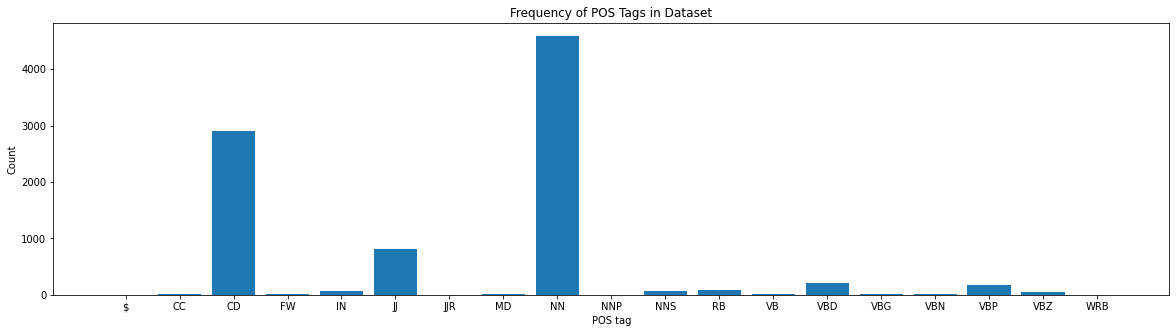

In [65]:
# plot data
import matplotlib.pylab as plt

graph_data = pos_count.items()
# Sort by POS tag names
graph_data = sorted(graph_data) 
x, y = zip(*graph_data) 
plt.figure(figsize=(20,5))
plt.xlabel("POS tag")
plt.ylabel("Count")
plt.title("Frequency of POS Tags in Dataset")
plt.bar(x, y)
plt.show()